![title](notebook_images/logo.png)

# Biometrics System Concepts
## Assignment 3: Face Recognition
<b>Name</b>: Alexandre Baré |
<b>Student-nr</b>: r0912072 |
<b>Date</b>: 28th May
---
Facial biometrics is among the most common biometric benchmarks. That is due to the easy deployment and implementation of such a system and the lack of requirement of physical interaction by the end-user. The top three application categories where facial recognition are mostly used are: 
* Security - law enforcement: e.g. to find missing children/disoriented adults, or to identify and track criminals  
* Health care: e.g. for detecting genetic diseases, pain management or monitoring response to medication. 
* Banking and retails: Since the beginning of the digital revolution, facial recognition has been picking up prominence over touch- and type-based interactions because of the convenience it offers without settling on the security of transactions. Facial Recognition softwares for banking usually have a liveness detection which keeps hackers from utilizing an image of the user for impersonation purposes. 

Any facial recognition system requires the implementation of the following steps:
<pre>
1. Face detection, to detect faces from a given image.
2. Feature extraction, to extract feature vector descriptors from the raw face image.
3. Face matching process, for verification or identification purposes.
</pre>

In this assignment, you will implement, test and report about a face recognition system based on Principal Components Analysis (Eigenfaces), Linear Discriminant Analysis (Fisherfaces), Local Binary Pattern (LBP) and deep learning. The first three procedures are representative of old-school computer vision techniques that are still in use and retain their merits. All four generated feature vector descriptors can be compared for verification/identification.

This document is structured as follows:
* [Ethics](#Ethics)
* [Importing and installing packages](#Importing-and-installing-packages)
* [I. Loading data](#I.-Loading-data)
    * Read caltech dataset
    * Inspect some images   
    
* [II. Face detection](#II.-Face-detection)
    * Detect faces
    * Print statistics of data
    * Visualise some faces
    
* [III. Feature-extraction](#III.-Feature-extraction)
    * Eigenfaces for face recognition
    * Fisherfaces for face recognition
    * LBP for face recognition
    * Deep metric learning
        
* [IV. Distance-based and classification-based scoring](#IV.-Distance-based-and-classification-based-scoring)
* [V. Evaluation](#V.-Evaluation)
    * Validation as verification system
    * Validation as identification system
    
* [VI. Tasks](#VI.-Tasks)
    * Mandatory tasks
    * Tasks of choice


** Note 1: In case you find yourself needing extra computational power you can make use of [google colab](https://colab.research.google.com/). However, implementing overly complicated routines is discouraged. **

**Note 2: large parts of this notebook are based on the [PyImageSearch Gurus Course on Computer Vision](https://www.pyimagesearch.com/pyimagesearch-gurus/) by Adrian Rosebrock.**

## Ethics
The ethical and societal challenge posed by data protection is radically affected by the use of facial recognition technologies.

In Europe and the UK, the [General Data Protection Regulation](https://www.thalesgroup.com/en/markets/digital-identity-and-security/government/biometrics/biometric-data) (GDPR) provides a rigorous framework for these practices.

Any investigations into a citizen's private life or business travel habits are out of the question, and any such invasions of privacy carry severe penalties. 

Applicable from May 2018, the GDPR supports the principle of a harmonized European framework, in particular protecting the right to be forgotten and the giving of consent through clear affirmative action.






## Importing and installing packages
Note: this exercise makes use of keras, which is now part of TensorFlow 2.0. It is easy to install using pip, have a look at the [installation guide](https://www.tensorflow.org/install) for more information. Note that you need Python Version 3.5 to 3.7 for this to run (not lower, not higher).

In [1]:
%reload_ext autoreload
%autoreload 2 # Automatically reload all modules after any modification

In [2]:
import numpy as np
import cv2
from pathlib import Path

from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm

# the following package contains some handy routines for image manipulation
# they have been developed by Adrian Rosenbrock
# simply install this package in your environment using "conda install imutils"
# see https://www.pyimagesearch.com/opencv-tutorials-resources-guides/ for further info
import imutils

# the following packages are imported when needed throughout this notebook, 
# we are only listing them here so that you can install all necessary packages upfront.
# pandas
# sklearn
# enum
# scipy
# tensorflow.keras

C:\Users\AlexandreBare\anaconda3\envs\Biometrics\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\AlexandreBare\anaconda3\envs\Biometrics\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\AlexandreBare\anaconda3\envs\Biometrics\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## I. Loading data

[From OpenCV Docs](https://docs.opencv.org/3.4/da/d60/tutorial_face_main.html):

In order to test face recognition systems, we need databases of labeled face images. You can either create your own dataset (but that takes time) or, better, start with one of the available face databases, http://face-rec.org/databases/ gives you an up-to-date overview. Some interesting databases are:

* [AT&T Facedatabase](https://cam-orl.co.uk/facedatabase.html). Quoted from http://face-rec.org):
> The AT&T Facedatabase, sometimes also referred to as ORL (Olivetti Research Lab) Database of Faces or Olivetti faces, contains ten different images of each of 40 distinct subjects. For some subjects, the images were taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement).The AT&T Facedatabase is good for initial tests, but it's a fairly easy database. The Eigenfaces method already has a 97% recognition rate on it, so you won't see any great improvements with other algorithms.

This database can be accessed in a straightforward way through the [sklearn.datasets.fetch_olivetti_faces](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_olivetti_faces.html#sklearn.datasets.fetch_olivetti_faces) module. 
A preview of this database can be seen [here](https://git-disl.github.io/GTDLBench/datasets/att_face_dataset/) 

* [The CALTECH Faces dataset](http://www.vision.caltech.edu/html-files/archive.html) is a popular benchmark dataset for face recognition algorithms. Overall, the dataset consists of 450 images of approximately 27 unique people. Each subject was captured under various lighting conditions, background scenes, and facial expressions. Furthermore, bounding box coordinates are provided to crop the faces prior to recognition. A routine (load_caltech_faces)is provided to read the data. 

![A sample of the CALTECH Faces dataset.](notebook_images/lbps_fr_caltech_faches.jpg)

* [The Labeled Faces in the Wild (lfw)](http://vis-www.cs.umass.edu/lfw/). This dataset is a collection of more than 13000 JPEG pictures of famous people collected over the internet. Each face has been labeled with the name of the person pictured. 1680 of the people pictured have two or more distinct photos in the data set. These images are completely unconstrained (pose, illumination, expression, occlusion).  The only constraint on these faces is that they were detected by the Viola-Jones face detector. Each picture is centered on a single face. A loader [sklearn.datasets.fetch_lfw_people](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html#sklearn.datasets.fetch_lfw_people) is provided by scikit-learn. 


### 1. Read caltech dataset
For this assignemnt we'll work with the CALTECH dataset because it contains raw images and is not very large. A copy of the dataset is available in the folder "CalTechFacesDirs".

The data are returned as a list object with the following components:
* data: (NxM) matrix of N flattened (linear dimension M) images
* images: (Nx(nxm)) matrix of N images of dimension nxm 
* target: N-dimensional vector of labels 

In [3]:
# size of each face after preprocessing
face_size=(47, 47)

In [4]:
import pandas as pd

def read_img(imagePath):
    # load the image and convert it to grayscale
    gray = cv2.imread(str(imagePath), cv2.IMREAD_GRAYSCALE)

    # ROI, and resize it to a canonical size
    imagePathStem = str(imagePath.stem)
    k = int(imagePathStem[imagePathStem.rfind("_") + 1:][:4]) - 1
    

    return gray, imagePath.parent.name
     
# grab in all the subdirs all the image paths associated with the faces
datasetPath = Path("CalTechFacesDirs")
imagePaths = datasetPath.glob("*/*.jpg")

# read image and label information
imgs = [read_img(imagePath) for imagePath in imagePaths]
data = pd.DataFrame(imgs, columns =['images', 'target']).to_dict('list')

# check if all images were found successfully 
# Please note that 5 images were removed from the original set, because 
# they wouldn't match the corresponding individual.
assert len(data['images']) == len(data['target']) == 445

In [5]:
# display data structure
# display(data)

### 2. Inspect some images

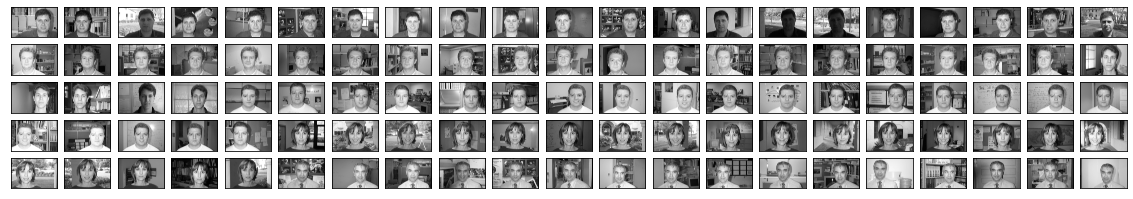

In [6]:
fig = plt.figure(figsize=(20, 20))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(5, 21), 
                 axes_pad=0.1,
                 )

for ax, im in zip(grid, data['images']):
    # Iterating over the grid returns the Axes.
    ax.imshow(im, cmap = 'gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

## II. Face detection


Even though the bounding box coordinates are stored in the <em>CalTechFacesDirs/ImageData.mat</em> file, we'll be computing them from scratch for demonstrative purposes. 

### 1. Detect faces
There are many different face detection algorithms, you can follow the [Learn OpenCV tutorial on Face Detection](https://www.learnopencv.com/face-detection-opencv-dlib-and-deep-learning-c-python/) for some (very coarse) background info for two "conventional" (HAAR-cascade, HOG) CV methods and two Deep Neural Net (Dlib) based (SSD, MMOD) methods.

* Some background on Haar, HOG and MMOD face detectors can be found in this [Guide to Face Detection in Python](https://towardsdatascience.com/a-guide-to-face-detection-in-python-3eab0f6b9fc1). 

* For MMOD specifically, see: [Max-Margin Object Detection by Davis E. King](http://arxiv.org/abs/1502.00046) and the comments at the beginning of the [dnn_mmod_ex.cpp code](https://github.com/davisking/dlib/blob/master/examples/dnn_mmod_ex.cpp).

* For further info on the Single-Shot-Multibox Detector, see [the arXiv publication](https://arxiv.org/abs/1512.02325).

In this assignment we'll be using HAAR, you can find more information about this technique on the [OpenCV website](https://docs.opencv.org/3.4/db/d28/tutorial_cascade_classifier.html).

In [7]:
faceCascade = cv2.CascadeClassifier('./models/haarcascade_frontalface_default.xml')

In [8]:
from sklearn.utils import Bunch
from sklearn.preprocessing import LabelEncoder

feat_data, images, labels = [], [], []


for img, label in zip(data['images'], data['target']):
    faces = faceCascade.detectMultiScale(
        img,
        scaleFactor = 1.2,
        minNeighbors = 9,
        minSize = (30, 30),
        flags = cv2.CASCADE_SCALE_IMAGE
    )

    # iterate faces found in image
    for (x, y, w, h) in faces:
        new_img = img.copy()
        
        # extract ROI
        raw_face = new_img[y:y+h, x:x+w]

        # resize the face to the preferred size
        face = cv2.resize(raw_face, face_size)
        face_flatten = face.flatten()
        
        images.append(np.expand_dims(face, axis=-1)), feat_data.append(face_flatten), labels.append(label)

# encode classes as integer value
label_encoder = LabelEncoder()
targets = label_encoder.fit_transform(labels)

faces = Bunch(data       = np.array(feat_data), 
              images     = np.array(images), 
              labels     = np.array(labels),
              target     = np.array(targets))

### 2. Print statistics of data

In [9]:
# extract number of samples and image dimensions (for later display)
n_samples, h, w, n_channels = faces.images.shape
imshape = (h, w, n_channels)

# count number of individuals
n_classes = faces.target.max() +1

n_features = faces.data.shape[1]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_classes: %d" % n_classes)
print("n_features: %d" % n_features)

Total dataset size:
n_samples: 440
n_classes: 26
n_features: 2209


### 3. Visualise some faces

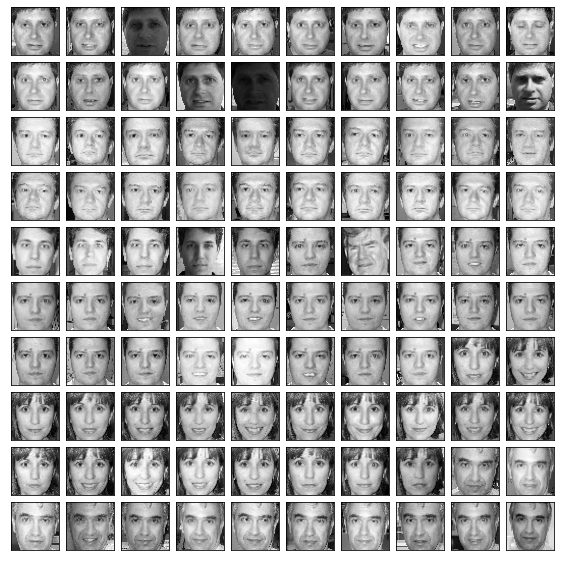

In [10]:
fig = plt.figure(figsize=(10, 10))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(10, 10), 
                 axes_pad=0.1,
                 )

for ax, im in zip(grid, faces['images']):
    # Iterating over the grid returns the Axes.
    ax.imshow(np.mean(im, -1), cmap = 'gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

## III. Feature extraction

Images tend to be large and can differ a lot in lighting, positioning, ... To combat this we'll extract features from each image using 4 different techniques. They all belong to the global/holistic feature representation approaches that map the image to a lower-dimensional subspace through linear and non-linear mapping. 

In [11]:
#from enum import Enum
from sklearn.model_selection import train_test_split

# split data for training and testing
holdout_split = lambda X,y: train_test_split(X, y, test_size=.25, shuffle = True, 
                                             stratify = y, random_state = 22)

class FeatureDescriptor():#Enum):
    LBP = 1
    PCA = 2
    LDA = 3
    DL = 4

######################################
# select the technique you want to use
# DESC = FeatureDescriptor.DL
######################################

# number of PCA/LDA components to retain
num_components = 35

# methods = ["LBP", "PCA", "LDA", "DL"]
df_features = pd.DataFrame(index = {"LBP", "PCA", "LDA", "DL-Euclidean", "DL-Cosine"},
                           columns = {"features", "dist_metric", "similarity_matrix", "score", "log_score", "f1_score", "accuracy", "balanced_accuracy", "far", "frr", "tpr", "precision", "recall", "cmc"})

### 1. Eigenfaces for face recognition

From [PyImageSearch Gurus Course on Computer Vision](https://www.pyimagesearch.com/pyimagesearch-gurus/) by Adrian Rosebrock:
>In 1971 Goldstein et al. [Identification of human faces](https://ieeexplore.ieee.org/document/1450184) demonstrated that facial characteristics can be manually extracted, quantified and used for face recognition. The question then remained: could this be done in an automatic fashion? 

>It wasn’t until the 1987 paper by Kirby and Sirovich ([A Low-Dimensional Procedure for the Characterization of Human Faces](https://www.researchgate.net/publication/19588504_Low-Dimensional_Procedure_for_the_Characterization_of_Human_Faces)) that we were able to answer this question. This paper is considered to be a seminal work in the history of computer vision — and while other approaches have since been proposed that can outperform Eigenfaces, it’s still important that we take the time to understand and appreciate this algorithm. [Turk and Pentland](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&cad=rja&uact=8&ved=2ahUKEwjmvqy6jqfhAhWFZFAKHb74DNgQFjAAegQIABAC&url=http%3A%2F%2Fwww.face-rec.org%2Falgorithms%2Fpca%2Fjcn.pdf&usg=AOvVaw2IlxVps8dldmeA01yQDa_I) built on this idea in the context of face recognition. 

>The Eigenfaces algorithm uses Principal Component Analysis to construct a low-dimensional representation of face images.

>![An example of applying an eigenvalue decomposition to a dataset of faces and extracting the 16 "eigenfaces" with the largest corresponding eigenvalue magnitude.](notebook_images/what_is_fr_eigenfaces.jpg)


>This involves collecting a dataset of faces with multiple face images per person we want to identify — like having multiple training examples of an image class we would want to label in image classification. Given this dataset of face images, presumed to be the same width, height, and ideally — with their eyes and facial structures aligned at the same (x, y)-coordinates, we apply an eigenvalue decomposition of the dataset, keeping the eigenvectors with the largest corresponding eigenvalues.

>Given these eigenvectors, a face can then be represented as a linear combination of what Kirby and Sirovich call eigenfaces.

>Face identification can be performed by computing the Euclidean distance between the eigenface representations and treating the face identification as a k-Nearest Neighbor classification problem — however, we tend to commonly apply more advanced machine learning algorithms to the eigenface representations.

>Last, it’s important to note that the Eigenfaces algorithm is **not-specific to faces** — we can actually apply it to any arbitrary dataset containing objects of the same type that need to be compared, whether that may be bicycles, cans of soup, or ancient Aztec coins. The Eigenfaces algorithm can be modified to accommodate each of these identification tasks.

In [12]:
from sklearn.decomposition import PCA
from scipy.spatial.distance import euclidean

# if DESC == FeatureDescriptor.PCA:
if True:
    # Compute a PCA (eigenfaces) on the face dataset
    num_components = min(num_components, min(n_samples, n_features))
    print("num_components {n}".format(n=num_components))
    desc = PCA(n_components=num_components, svd_solver='randomized', whiten=True).fit(faces.data)
    X_pca = desc.transform(faces.data)
    embedded = X_pca
    
    dist_metric = euclidean

    df_features.loc["PCA"] = pd.Series({"features": embedded, "dist_metric": dist_metric})

num_components 35


### 2. Fisherfaces for face recognition

From [Scholarpaedia](http://www.scholarpedia.org/article/Fisherfaces):
> When the goal is classification rather than representation, PCA may not yield the most desirable results. In such cases, one wishes to find a subspace that maps the sample vectors of the same class in a single spot of the feature representation and those of different classes as far apart from each other as possible. The techniques derived to achieve this goal are known as discriminant analysis (DA).
The most known DA is Linear Discriminant Analysis (LDA), which can be derived from an idea suggested by R.A. Fisher in 1936. When LDA is used to find the subspace representation of a set of face images, the resulting basis vectors defining that space are known as [Fisherfaces](http://www.scholarpedia.org/article/Fisherfaces).

![Example of FisherFaces](notebook_images/FisherFaces.jpg)

In [13]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.spatial.distance import euclidean

# if DESC == FeatureDescriptor.LDA:
if True:
    num_components = min(num_components, min(n_classes - 1, n_features))
    desc = LinearDiscriminantAnalysis(n_components=num_components).fit(faces.data, faces.target)
    X_lda = desc.fit_transform(faces.data, faces.target)
    embedded = X_lda
    
    dist_metric = euclidean
    df_features.loc["LDA"] = pd.Series({"features": embedded, "dist_metric": dist_metric})

### 3. LBP for face recognition

Local Binary Patterns, or LBPs for short, are a texture descriptor made popular by the work of Ojala et al. in their 2002 paper, [Multiresolution Grayscale and Rotation Invariant Texture Classification with Local Binary Patterns](https://ieeexplore.ieee.org/document/1017623) (although the concept of LBPs were introduced as early as 1993).

Unlike [Haralick texture features](http://haralick.org/journals/TexturalFeatures.pdf) that compute a global representation of texture based on the [Gray Level Co-occurrence Matrix](https://en.wikipedia.org/wiki/Co-occurrence_matrix), LBPs instead compute a local representation of texture. This local representation is constructed by comparing each pixel with its surrounding neighborhood of pixels. See [PyImageSearch](https://www.pyimagesearch.com/2015/12/07/local-binary-patterns-with-python-opencv/) and [Scikit-Image](http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_local_binary_pattern.html) for further details on LBP.
![LBP](notebook_images/LBP.png)

In [14]:
from localmodules.local_binary_patterns import LBP
from scipy.stats import chisquare

# Hint: If you get NaN values as a result of Chi-Square, feel free to use the following function:

def CHI2(histA, histB, eps=1e-10):
    # compute the chi-squared distance
    d = 0.5 * np.sum(((histA - histB) ** 2) / (histA + histB + eps))

    # return the chi-squared distance
    return d

# if DESC == FeatureDescriptor.LBP:
if True:
    desc = LBP(numPoints=8, radius=1, grid_x=7, grid_y=7)
    embedded = desc.describe_list(faces.images[...,0])
    
    dist_metric = CHI2 #chisquare
    
    df_features.loc["LBP"] = pd.Series({"features": embedded, "dist_metric": dist_metric})
    

### 4. Deep metric learning
Similar to previous techniques, we can use deep learning to generate an enriched representation of faces that you can use in simple or more complicated classification algorithms. 
Instead of building networks that are trained end-to-end to perform face recognition, we will use deep metric learning. Metric learning based methods learn a projection of the input data on a low-dimensional vector, such that classification in that lower-dimensional space is much easier and can be performed using simple distance metrics. 

In the context of face recognition we can observe the following major Deep Learning based approaches since 2014.

1. The first approach was developed and presented in 2014 by researchers at Facebook and is called [DeepFace](https://www.cs.toronto.edu/~ranzato/publications/taigman_cvpr14.pdf) . The major contributions where a CDNN to classify faces. In addition a 3D/2D alignment procedure is applied prior to classification. 
The CDNN is trained as a classifier on the SFC (Social Face Classification) dataset, which is a very large (4.4 million image of 4000 individuals) dataset. This setting is called supervised.  The challenge is whether this can also be generalizd to other datasets and subjects as well. By training it on the large collection of uncontrolled images, an embedded representation (the vector description prior to the classification layer) can be generated that is, allegedly, generalizable to other face recognition data. One can then use this representation as we have previously done for classical representations. 
By way of demonstration they tested it on the LFW dataset to achieve >0.95% verification accuracy. <br> 

2. The second approach was developed by researchers at Google.  An in-depth presentation of their FaceNet/OpenFace deep CNN's for metric embedding of faces is given by [Martin Krasser et al](http://krasserm.github.io/2018/02/07/deep-face-recognition/). Note that this method was trained on 200 million images of eight million identities. The main methodological point is that these networks are trained using a special loss-function: the triplet loss function. 
>This function is minimized when the distance between an anchor image $x_{ai}$ and a positive image $x_{pi}$ (same identity) in embedding space is smaller than the distance between that anchor image and a negative image $x_{ni}$ (different identity) by at least a margin $\alpha$. Model training aims to learn an embedding f(x) of image x such that the squared L2 distance between all faces of the same identity is small and the distance between a pair of faces from different identities is large. 







There is a very elegant Python implementations available of the FaceNet/OpenFace approach. It is nicely described in [this PyImageSearch tutorial](https://www.pyimagesearch.com/2018/06/18/face-recognition-with-opencv-python-and-deep-learning/). It explicitly includes the Dlib package with the [face_recognition modules](https://face-recognition.readthedocs.io/en/latest/index.html) for face detection and recognition. Especially the latter package provides a very convenient interface. 

From the [Dlib face_recognition.py](https://github.com/davisking/dlib/blob/master/python_examples/face_recognition.py) code, we get an application view of the embedding:

> This example shows how to use dlib's face recognition tool.  This tool maps an image of a human face to a 128 dimensional vector space where images of the same person are near to each other and images from different people are far apart.  Therefore, you can perform face recognition by mapping faces to the 128D space and then checking if their Euclidean distance is small enough. 

> When using a distance threshold of 0.6, the dlib model obtains an accuracy of 99.38% on the standard LFW face recognition benchmark, which is comparable to other state-of-the-art methods for face recognition as of February 2017. This accuracy means that, when presented with a pair of face images, the tool will correctly identify if the pair belongs to the same person or is from different people 99.38% of the time.

In the [DeepFace](https://www.cs.toronto.edu/~ranzato/publications/taigman_cvpr14.pdf) paper they also tested a [siamese network](https://en.wikipedia.org/wiki/Siamese_network) DNN architecture for generating embedded vector representations.  This consists of two copies of the same CNN (sharing their weights) that are applied to pairs of images. During training the distance between the embedded representations of the same individual is minimized, and the distances between embedded representations of different individuals is maximized. In the mean time, this work was extended, steadily increasing the performance. Siamese networks are an example of *One-shot Learning* where you tyically have very few samples per object or dynamically changing number of objects/subjects. While [this link](https://towardsdatascience.com/one-shot-learning-with-siamese-networks-using-keras-17f34e75bb3d) tests it on a non-face recognition task, it can be applied to face recognition as well.

The localmodules.siamese file contains the description of a shallow CNN model that is trained with [contrastive loss](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf).
This subnetwork is copied twice and the output of both siamese copies are then passed onto a vector euclidean distance (ED) calculation layer. The network gets as input pairs of imposter or genuine images with the associated label (genuine = 0, imposter = 1). You can make use of the output of the network or the output before the ED layer (embedded) in your validation.

Note: this part on Siamese networks is adapted from [Packt tutorial](https://hub.packtpub.com/face-recognition-using-siamese-networks-tutorial/), which seems to be a re-implementation from  [this Packt book on Neural Network Projects with Python](https://subscription.packtpub.com/book/big_data_and_business_intelligence/9781789138900)). See also [this Hackernoon tutorial](https://hackernoon.com/one-shot-learning-with-siamese-networks-in-pytorch-8ddaab10340e).

Note: you can change the CNN at your will, but beware that it might take additional training time.

In [15]:
# Fix seeds and create tensorflow session for reproducible results
import tensorflow as tf
from keras import backend as K

SEED=42
np.random.seed(SEED)
tf.random.set_seed(SEED)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

#### 4.1 DL with euclidean distance

In [16]:
# If you encounter problem importing the siamese model, consider using Google Colab.
import localmodules.siamese as siamese
distance_str = 'euclidean'
encoder, model = siamese.create_siamese_model(imshape, distance_str)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 47, 47, 1)]  0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 47, 47, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 128)          894400      ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 lambda (Lambda)                (None, 1)            0           ['sequential[0][0]',         

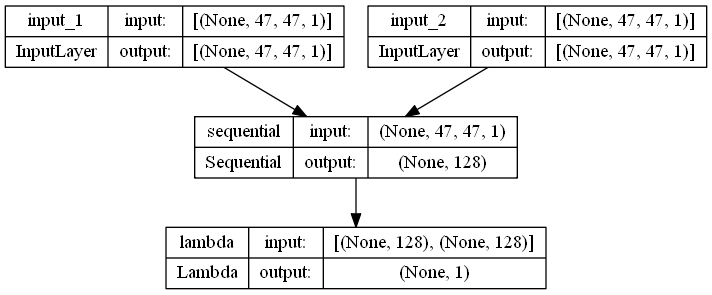

In [17]:
# To visualize your model structure:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes = True, show_layer_names = True)

Depending on the complexity of the Siamese network this might take a while. You can also change the number of epochs to improve the training (with the risk of overfitting). You will notice that a small number (<10) of epochs already gets you a decent performance.

In [18]:
import localmodules.siamese as siamese
from tensorflow.keras.optimizers import RMSprop, Adam

from scipy.spatial.distance import euclidean
from sklearn import metrics

# if DESC == FeatureDescriptor.DL:
if True:
    x_train, x_test, y_train, y_test = holdout_split(*siamese.get_siamese_paired_data(faces.images, faces.target))
    rms = Adam()
    model.compile(
        loss=siamese.contrastive_loss, 
        optimizer=rms, 
        metrics = [siamese.accuracy],
        run_eagerly=True)

    epochs = 10
    model.fit([x_train[:, 0], x_train[:, 1]], y_train, 
              validation_split=0.2,
              batch_size=32, verbose=2, epochs=epochs)
    

Epoch 1/10
38/38 - 7s - loss: 0.0872 - accuracy: 0.7738 - val_loss: 0.0500 - val_accuracy: 0.9156 - 7s/epoch - 189ms/step
Epoch 2/10
38/38 - 3s - loss: 0.0336 - accuracy: 0.9482 - val_loss: 0.0348 - val_accuracy: 0.9438 - 3s/epoch - 91ms/step
Epoch 3/10
38/38 - 1s - loss: 0.0220 - accuracy: 0.9778 - val_loss: 0.0293 - val_accuracy: 0.9479 - 1s/epoch - 35ms/step
Epoch 4/10
38/38 - 1s - loss: 0.0148 - accuracy: 0.9877 - val_loss: 0.0233 - val_accuracy: 0.9781 - 1s/epoch - 30ms/step
Epoch 5/10
38/38 - 1s - loss: 0.0105 - accuracy: 0.9942 - val_loss: 0.0235 - val_accuracy: 0.9719 - 1s/epoch - 30ms/step
Epoch 6/10
38/38 - 1s - loss: 0.0086 - accuracy: 0.9992 - val_loss: 0.0192 - val_accuracy: 0.9844 - 1s/epoch - 27ms/step
Epoch 7/10
38/38 - 1s - loss: 0.0073 - accuracy: 0.9992 - val_loss: 0.0180 - val_accuracy: 0.9875 - 959ms/epoch - 25ms/step
Epoch 8/10
38/38 - 1s - loss: 0.0057 - accuracy: 1.0000 - val_loss: 0.0155 - val_accuracy: 0.9875 - 956ms/epoch - 25ms/step
Epoch 9/10
38/38 - 1s - l

In [19]:
if True:
    test_scores = model.predict([x_test[:, 0], x_test[:, 1]])
    test_acc = metrics.accuracy_score(y_test, test_scores > 0.5)
    print("Accuracy on the test set: {}".format(test_acc))
    embedded = encoder(faces.images.astype(np.float32)).numpy()

    dist_metric = euclidean
    df_features.loc["DL-Euclidean"] = pd.Series({"features": embedded, "dist_metric": dist_metric})

16/16 [==============================] - 0s 9ms/step
Accuracy on the test set: 0.994


#### 4.2 DL with cosine distance (= 1 - cosine_similarity)

In [20]:
SEED=42
np.random.seed(SEED)
tf.random.set_seed(SEED)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [21]:
from scipy.spatial.distance import cosine as cosine_distance

distance_str = 'cosine'
encoder, model = siamese.create_siamese_model(imshape, distance_str)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 47, 47, 1)]  0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 47, 47, 1)]  0           []                               
                                                                                                  
 sequential_1 (Sequential)      (None, 128)          894400      ['input_3[0][0]',                
                                                                  'input_4[0][0]']                
                                                                                                  
 lambda_1 (Lambda)              (None, 1)            0           ['sequential_1[0][0]',     

In [22]:
# if DESC == FeatureDescriptor.DL:
if True:
    rms = Adam(learning_rate=0.0001)
    model.compile(
        loss=siamese.contrastive_loss, 
        optimizer=rms, 
        metrics = [siamese.accuracy],
        run_eagerly=True)

    epochs = 15
    model.fit([x_train[:, 0], x_train[:, 1]], y_train, 
              validation_split=0.2,
              batch_size=4, verbose=1, epochs=epochs)
    

Epoch 1/15
300/300 [==============================] - 8s 25ms/step - loss: 0.2129 - accuracy: 0.5067 - val_loss: 0.1490 - val_accuracy: 0.5867
Epoch 2/15
300/300 [==============================] - 8s 26ms/step - loss: 0.2127 - accuracy: 0.5025 - val_loss: 0.1994 - val_accuracy: 0.5533
Epoch 3/15
300/300 [==============================] - 8s 26ms/step - loss: 0.1765 - accuracy: 0.5442 - val_loss: 0.1720 - val_accuracy: 0.5633
Epoch 4/15
300/300 [==============================] - 9s 29ms/step - loss: 0.1440 - accuracy: 0.6008 - val_loss: 0.0943 - val_accuracy: 0.7200
Epoch 5/15
300/300 [==============================] - 8s 28ms/step - loss: 0.0971 - accuracy: 0.7050 - val_loss: 0.1195 - val_accuracy: 0.6267
Epoch 6/15
300/300 [==============================] - 8s 26ms/step - loss: 0.0676 - accuracy: 0.7975 - val_loss: 0.0670 - val_accuracy: 0.8133
Epoch 7/15
300/300 [==============================] - 8s 26ms/step - loss: 0.0398 - accuracy: 0.8992 - val_loss: 0.0469 - val_accuracy: 0.8767

In [23]:
if True:
    test_scores = model.predict([x_test[:, 0], x_test[:, 1]])
    test_acc = metrics.accuracy_score(y_test, test_scores > 0.5)
    print("Accuracy on the test set: {}".format(test_acc))
    embedded = encoder(faces.images.astype(np.float32)).numpy()

    dist_metric = cosine_distance
    df_features.loc["DL-Cosine"] = pd.Series({"features": embedded, "dist_metric": dist_metric})

16/16 [==============================] - 0s 19ms/step
Accuracy on the test set: 0.962


## IV. Distance-based and classification-based scoring

Biometrics is based on generating pairwise matching scores. In it's simplest form, the score is computed based on the distance metrics (distance-based scoring). E.g. a simple pairwise comparision (L2-distance, e.g.) can be used. 

* In verification mode one compares this matching score to a decision threshold in a 1-to-1 setting.
* In identifcation mode one uses this matching score to rank the templates in the database and, possibly, thresholding it as well in a 1-to-N setting
 

On the other hand, some classification algorithms provide us with the classification scores (or probabilities), which are related to the likelihood that an image belongs to each subject in the dataset. These classification scores can be seen as an advanced classification-based matching score. 

* In verification mode one compares the soft scores (or probabilities) of the classification with a threshold to verify whether the person is who he claims to be.
* In identifcation mode one sorts the soft scores to propose the most similar people in the dataset.

To implement a classification-based system (optional task 3), the following steps are expected:
1. For each person in the dataset leave one image out (E.g. the first image in the dataset) for the testset. This means the size of the test set equals the number of individuals in the data (=n).
2. Run the classifier of your choice and generate the classification probabilities for each test image.
3. Build your n by n similarity matrix, in which each row corresponds to a test image and each column corresponds to an individual in the dataset.
4. Calculate the evaluation metrics (E.g. ROC) based on the obtained similarity matrix to test your system in a verification or identification scenario.

In [54]:
SAVE_OUTPUT = True
output_folder = 'output/'
img_format = '.png'
figsize = (8, 8)
plt.rcParams.update({'font.size': 14})

<div class="alert alert-block alert-success">
<b>Q1: </b> Compute distance-based pair-wise matching scores.
</div>

Given the function <em>dist_metric</em> and the vector representations in variable <em>embedded</em>, compute the pairwise distances. Do this for PCA, LDA, LBP and a DL facial representations, given the code above.

### Pair-wise distance-based matching scores

In [25]:
method = df_features.index[0] # select method from the dataframe indexes
matching_scores = np.zeros((n_samples, n_samples))
for i1 in range(len(embedded)):
    for i2 in range(len(embedded)):
        matching_scores[i1][i2] = dist_metric(df_features.loc[method, 'features'][i1], df_features.loc[method, 'features'][i2]) # pair-wise distance

### Similarity matrix

In [26]:
def similarity_metric(x, y, dist_func=dist_metric):
    sim = 1 / (1 + dist_func(x, y))
    return np.nan_to_num(sim , 0)

In [27]:
def get_similarity_matrix(representations, similarity_func):
    n_samples = len(representations)
    similarity_matrix = np.zeros((n_samples, n_samples))
    for i1 in range(n_samples):
        for i2 in range(n_samples):
            similarity_matrix[i1][i2] = similarity_func(representations[i1], representations[i2]) # pair-wise similarity
    return similarity_matrix

In [28]:
for method in tqdm(df_features.index):
    similarity_matrix = get_similarity_matrix(df_features.loc[method, "features"], 
                                              lambda x, y: similarity_metric(x, y, df_features.loc[method, "dist_metric"]))
    df_features.loc[method, "similarity_matrix"] = similarity_matrix

 60%|██████    | 3/5 [00:27<00:18,  9.19s/it]C:\Users\AlexandreBare\AppData\Roaming\Python\Python38\site-packages\scipy\spatial\distance.py:720: RuntimeWarning: invalid value encountered in float_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
100%|██████████| 5/5 [00:53<00:00, 10.76s/it]


### Similarity-based genuine-impostor scores

In [29]:
def representations_2_genuine_scores(classes, representations, similarity_func):
    similarity_matrix = get_similarity_matrix(representations, similarity_func)
    
    genuine_id = []
    scores = []
    for i1 in range(len(similarity_matrix)):
        for i2 in range(len(similarity_matrix[0])):
            if i1 != i2:
                scores.append(similarity_matrix[i1][i2])
                if classes[i1] == classes[i2]:
                    genuine_id.append(1)
                else:
                    genuine_id.append(0)
    # Normalize the scores in range [0, 1]
    scores = np.array(scores)
    scores = (scores - scores.min())/(scores.max() - scores.min())
    return np.array(genuine_id), scores

In [30]:
for method in tqdm(df_features.index):
    genuine_id, scores = representations_2_genuine_scores(faces.target, 
                                                          df_features.loc[method, "features"], 
                                                          lambda x, y: similarity_metric(x, y, df_features.loc[method, "dist_metric"]))
    df_features.loc[method, "score"] = scores
    df_features.loc[method, "log_score"] = np.log(scores)

  0%|          | 0/5 [00:00<?, ?it/s]C:\Users\ALEXAN~2\AppData\Local\Temp/ipykernel_2632/216725030.py:6: RuntimeWarning: divide by zero encountered in log
  df_features.loc[method, "log_score"] = np.log(scores)
100%|██████████| 5/5 [00:54<00:00, 10.86s/it]


## V. Evaluation

In this section you can re-use the code you developed for validation in the previous assignments, and in particular assignment 1. 

### 1. Validation as verification system

In [31]:
from score import *

In [32]:
thresholds = np.linspace(scores.min(), scores.max(), 100)

In [33]:
# method = 'DL-Cosine'
for method in tqdm(df_features.index):
    df_features.loc[method, "f1_score"] = []

100%|██████████| 5/5 [00:00<00:00, 5001.55it/s]


In [34]:
for method in tqdm(df_features.index):
    for threshold in thresholds:
        curr_f1_score = f1_score(genuine_id, df_features.loc[method, "score"], threshold)
        if df_features.loc[method, "f1_score"] is np.nan:
            df_features.loc[method, "f1_score"] = [curr_f1_score]
        else:
            df_features.loc[method, "f1_score"].append(curr_f1_score)

100%|██████████| 5/5 [00:14<00:00,  2.95s/it]


In [35]:
for method in tqdm(df_features.index):
    for threshold in thresholds:
        curr_accuracy = accuracy_score(genuine_id, df_features.loc[method, "score"], threshold)
        if df_features.loc[method, "accuracy"] is np.nan:
            df_features.loc[method, "accuracy"] = [curr_accuracy]
        else:
            df_features.loc[method, "accuracy"].append(curr_accuracy)

100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


In [36]:
for method in tqdm(df_features.index):
    for threshold in thresholds:
        curr_balanced_accuracy = balanced_accuracy_score(genuine_id, df_features.loc[method, "score"], threshold)
        if df_features.loc[method, "balanced_accuracy"] is np.nan:
            df_features.loc[method, "balanced_accuracy"] = [curr_balanced_accuracy]
        else:
            df_features.loc[method, "balanced_accuracy"].append(curr_balanced_accuracy)

100%|██████████| 5/5 [00:06<00:00,  1.33s/it]


In [37]:
for method in tqdm(df_features.index):
    far_list = [fpr(genuine_id, df_features.loc[method, 'score'], threshold) for threshold in thresholds]
    df_features.loc[method, 'far'] = far_list
    tpr_list = [tpr(genuine_id, df_features.loc[method, 'score'], threshold) for threshold in thresholds]
    df_features.loc[method, 'tpr'] = tpr_list
    frr_list = 1-np.array(tpr_list)
    df_features.loc[method, 'frr'] = frr_list

100%|██████████| 5/5 [02:47<00:00, 33.42s/it]


In [38]:
"""Calculate the Precision and Recall for this system"""
for method in tqdm(df_features.index):
    precision, recall, pr_thresholds = metrics.precision_recall_curve(genuine_id, df_features.loc[method, 'score'])
    df_features.loc[method, 'precision'] = precision
    df_features.loc[method, 'recall'] = recall

100%|██████████| 5/5 [00:00<00:00, 45.44it/s]


In [39]:
"""Calculate the Cumulative Matching Characteristic curve."""
unique_targets, unique_target_indices = np.unique(faces.target, return_index=True)
unique_target_mask = np.zeros(len(faces.target), dtype=bool)
unique_target_mask[unique_target_indices] = True
true_targets = faces.target[~unique_target_mask]

rank = len(unique_targets)
for method in df_features.index:
    similarity_matrix = df_features.loc[method, 'similarity_matrix']
    similarity_matrix = similarity_matrix[unique_target_mask][:, ~unique_target_mask]
    similarity_matrix = pd.DataFrame(similarity_matrix) # (n_ref_samples=n_class, n_probe_samples)
    similarity_matrix.index = unique_targets
    cmc_list = cmc(true_targets, similarity_matrix, rank)
    df_features.loc[method, 'cmc'] = cmc_list

100%|██████████| 25/25 [00:00<00:00, 2778.13it/s]


In [40]:
"""Calculate (by approximation) the EER and plot it on the FAR-FRR curve."""
for method in tqdm(df_features.index):
    scores = df_features.loc[method, 'score']
    far_list = df_features.loc[method, 'far']
    frr_list = df_features.loc[method, 'frr']
    (eer_far, eer_frr), eer_threshold = fast_eer(far_list, frr_list, thresholds, return_threshold=True)
    # (eer_far, eer_frr), eer_threshold = eer(genuine_id, scores, thresholds, return_threshold=True)
    df_features.loc[method, 'eer_far'] = eer_far
    df_features.loc[method, 'eer_frr'] = eer_frr
    df_features.loc[method, 'eer_threshold'] = eer_threshold

  0%|          | 0/5 [00:00<?, ?it/s]
100it [00:00, ?it/s]A

100it [00:00, ?it/s]A

100it [00:00, ?it/s]A

100it [00:00, ?it/s]A

100it [00:00, 99864.38it/s]
100%|██████████| 5/5 [00:00<00:00, 333.30it/s]


<div class="alert alert-block alert-success">
<b>Q2: </b> Compute F1 and accuracy scores for variable (and optimal) thresholds
</div>

* Calculate and plot F1 and accuracy scores for a range (min, max) of thresholds.
* Determine some optimal threshold (look up in classification literature). Justify your answer.

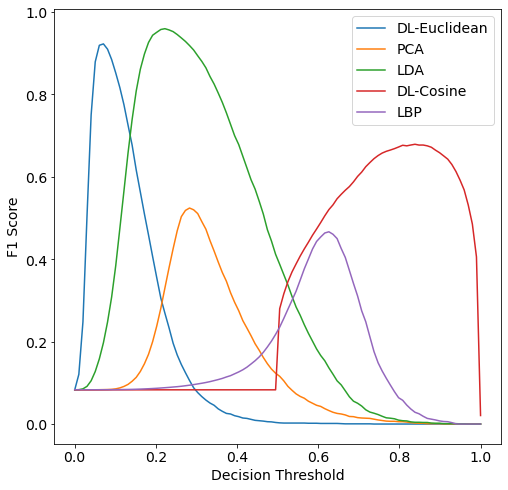

In [55]:
plt.figure(figsize=figsize)
for method in df_features.index:
    plt.plot(thresholds, df_features.loc[method, "f1_score"], label=method)
plt.ylabel('F1 Score')
plt.xlabel('Decision Threshold')
plt.legend()
if SAVE_OUTPUT:
    plt.savefig(output_folder + 'f1_score' + img_format)

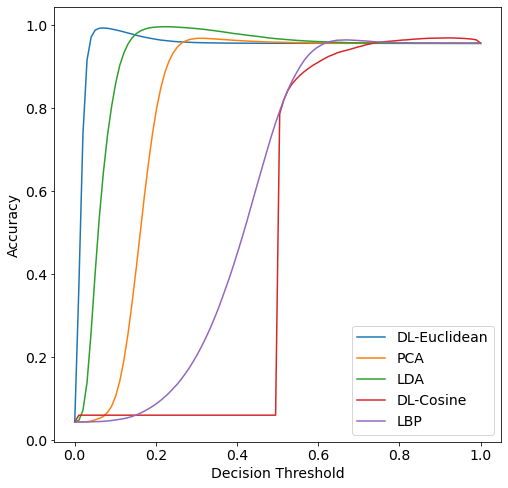

In [56]:
fig = plt.figure(figsize=figsize)
for method in df_features.index:
    plt.plot(thresholds, df_features.loc[method, "accuracy"], label=method)
plt.xlabel('Decision Threshold')
plt.ylabel('Accuracy')
plt.legend()
if SAVE_OUTPUT:
    fig.savefig(output_folder + 'accuracy' + img_format)

In [57]:
for method in df_features.index:
    print(f"Method {method}")
    accuracy = df_features.loc[method, "accuracy"]
    threshold_max_accuracy = thresholds[np.argmax(accuracy)]
    print(f"Max accuracy ({np.max(accuracy)}) at threshold {threshold_max_accuracy}")
    
    balanced_accuracy = df_features.loc[method, "balanced_accuracy"]
    threshold_max_balanced_accuracy = thresholds[np.argmax(balanced_accuracy)]
    print(f"Max balanced accuracy ({np.max(balanced_accuracy)}) at threshold {threshold_max_balanced_accuracy}")
    
    f1_score_list = df_features.loc[method, "f1_score"]
    threshold_max_f1_score = thresholds[np.argmax(f1_score_list)]
    print(f"Max f1-score ({np.max(f1_score_list)}) at threshold {threshold_max_f1_score}")
    
    tpr_list = df_features.loc[method, "tpr"]
    tnr_list = 1-np.array(df_features.loc[method, "far"])
    gm_tpr_tnr = np.sqrt(np.array(tpr_list) * np.array(tnr_list))
    threshold_max_GM_tpr_tnr = thresholds[np.argmax(gm_tpr_tnr)]
    print(f"Max geometric mean of TPR and TNR ({np.max(gm_tpr_tnr)}) at threshold {threshold_max_GM_tpr_tnr}")
    
    threshold_eer = df_features.loc[method, 'eer_threshold']
    print(f"Equal Error Rate (FAR=FRR={df_features.loc[method, 'eer_far']}) at threshold {threshold_eer}")

Method DL-Euclidean
Max accuracy (0.9934354938910748) at threshold 0.07070707070707072
Max balanced accuracy (0.9758390234256169) at threshold 0.05050505050505051
Max f1-score (0.9227017800536454) at threshold 0.07070707070707072
Max geometric mean of TPR and TNR (0.9757408208951598) at threshold 0.05050505050505051
Equal Error Rate (FAR=FRR=0.028797228537403918) at threshold 0.04040404040404041
Method PCA
Max accuracy (0.9685545661627666) at threshold 0.31313131313131315
Max balanced accuracy (0.7706994384095565) at threshold 0.22222222222222224
Max f1-score (0.5245105045019295) at threshold 0.2828282828282829
Max geometric mean of TPR and TNR (0.7617781684626305) at threshold 0.21212121212121213
Equal Error Rate (FAR=FRR=0.2593482732488903) at threshold 0.19191919191919193
Method LDA
Max accuracy (0.9965313729550631) at threshold 0.22222222222222224
Max balanced accuracy (0.9839484238875101) at threshold 0.16161616161616163
Max f1-score (0.9596142254370102) at threshold 0.22222222222

<div class="alert alert-block alert-success">
<b>Q3: </b> Plot genuine and impostor scores
</div>
When comparing the different feature extractions/facial representations, discuss the difference in the overlap between genuine and imposter scores.

<Figure size 576x576 with 0 Axes>

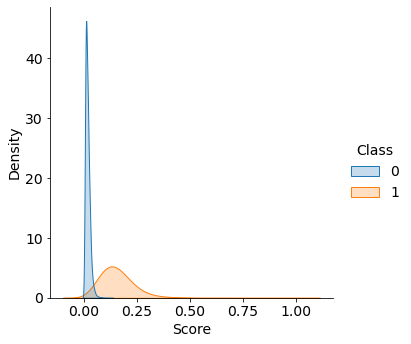

<Figure size 576x576 with 0 Axes>

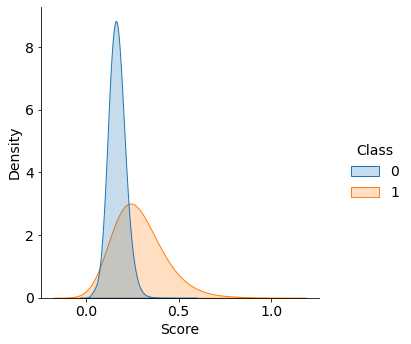

<Figure size 576x576 with 0 Axes>

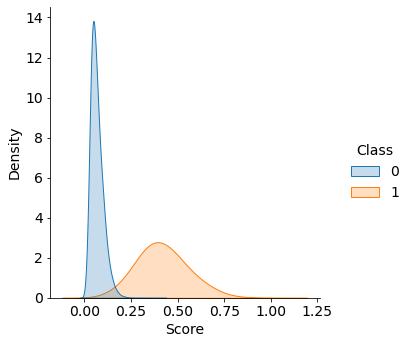

<Figure size 576x576 with 0 Axes>

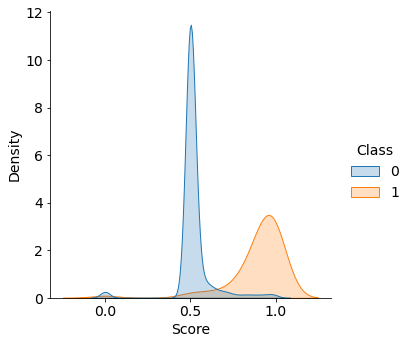

<Figure size 576x576 with 0 Axes>

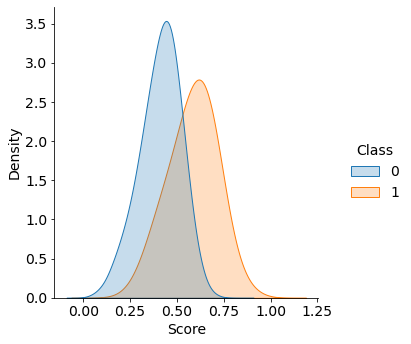

In [58]:
import seaborn as sns
for method in df_features.index:
    fig = plt.figure(figsize=figsize)
    df_scores = pd.DataFrame({'Class': genuine_id.astype('int'), 'Score': df_features.loc[method, 'score'], 'LogScore': df_features.loc[method, 'log_score']})
    sns.displot(df_scores, x='Score', hue='Class', kind='kde', common_norm=False, fill=True, bw_adjust=3)#4.5)
    if SAVE_OUTPUT:
        plt.savefig(output_folder + method + '/' + 'class_distribution' + img_format)

<div class="alert alert-block alert-success">
<b>Q4: </b> Perform a full-on verification assessment based on the scores obtained. Interpret the results.
</div>

Hint: Calculate and plot the equal error rate. Plot the precision-recall curve and compute AUC and average precision. Interpret the results e.g. by explaining what aspect of the system performance is explored by each metric.

  0%|          | 0/5 [00:00<?, ?it/s]

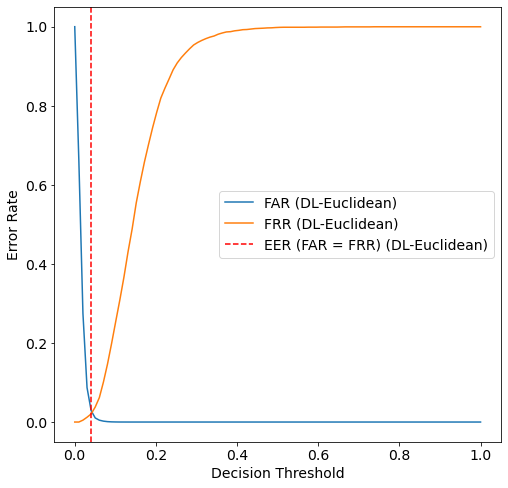

 20%|██        | 1/5 [00:00<00:00,  6.30it/s]

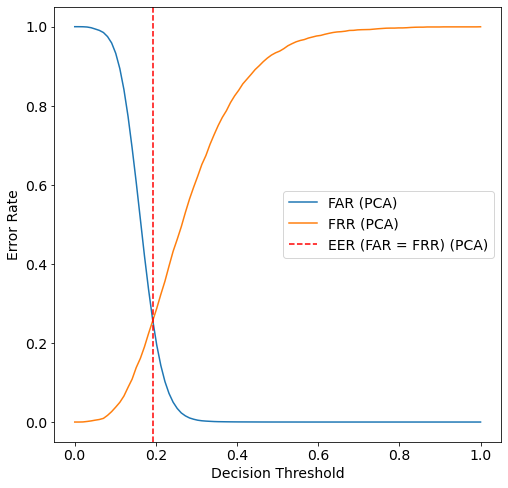

 40%|████      | 2/5 [00:00<00:00,  6.36it/s]

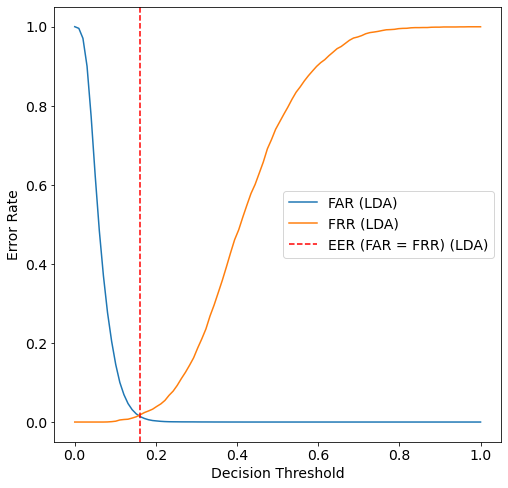

 60%|██████    | 3/5 [00:00<00:00,  6.20it/s]

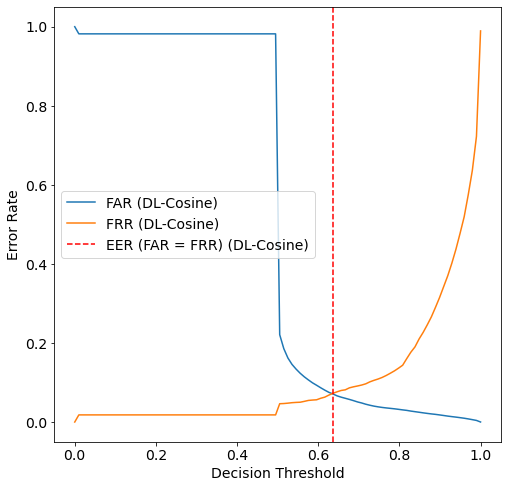

 80%|████████  | 4/5 [00:00<00:00,  6.22it/s]

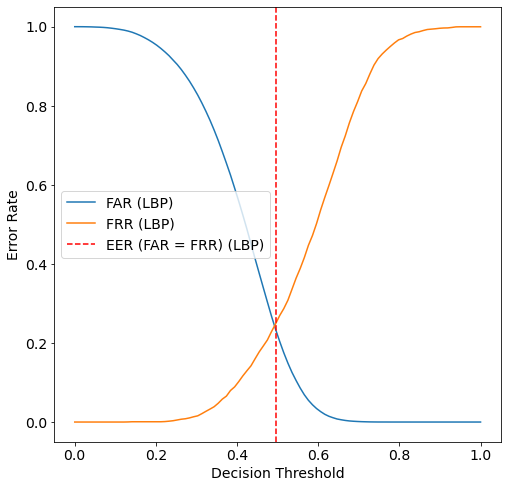

100%|██████████| 5/5 [00:00<00:00,  6.14it/s]


In [59]:
for method in tqdm(df_features.index):
    fig = plt.figure(figsize=figsize)
    plt.plot(thresholds, df_features.loc[method, 'far'], label=f'FAR ({method})')
    plt.plot(thresholds, df_features.loc[method, 'frr'], label=f'FRR ({method})')
    plt.axvline(x = df_features.loc[method, 'eer_threshold'], color = 'red', linestyle='--', label=f'EER (FAR = FRR) ({method})')
    plt.xlabel('Decision Threshold')
    plt.ylabel('Error Rate')
    plt.legend()
    plt.show()
    if SAVE_OUTPUT:
        fig.savefig(output_folder + method + '/'+ 'far_frr' + img_format)

100%|██████████| 5/5 [00:00<00:00, 294.13it/s]


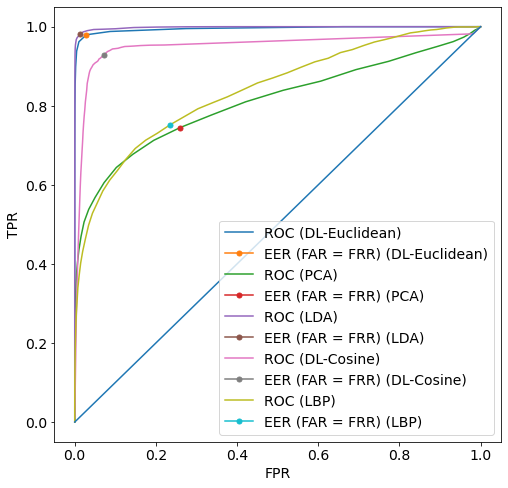

In [60]:
fig = plt.figure(figsize=figsize)
for method in tqdm(df_features.index):
    plt.plot(df_features.loc[method, 'far'], df_features.loc[method, 'tpr'], label=f'ROC ({method})')
    plt.plot(df_features.loc[method, 'eer_far'], 1-df_features.loc[method, 'eer_frr'], marker="o", markersize=5, label=f'EER (FAR = FRR) ({method})')
plt.plot(thresholds, thresholds)
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.legend()
plt.show()
if SAVE_OUTPUT:
    fig.savefig(output_folder + 'roc' + img_format)

In [61]:
"""Calculate the ROC AUC."""
for method in tqdm(df_features.index):
    roc_auc = metrics.roc_auc_score(genuine_id, df_features.loc[method, "score"])
    print(f'ROC AUC for {method}: {roc_auc}')

100%|██████████| 5/5 [00:00<00:00, 28.32it/s]

ROC AUC for DL-Euclidean: 0.9954632523284312
ROC AUC for PCA: 0.8109255480579113
ROC AUC for LDA: 0.9984974967708357
ROC AUC for DL-Cosine: 0.9505697228203109
ROC AUC for LBP: 0.84012165521448


100%|██████████| 5/5 [00:00<00:00, 277.82it/s]


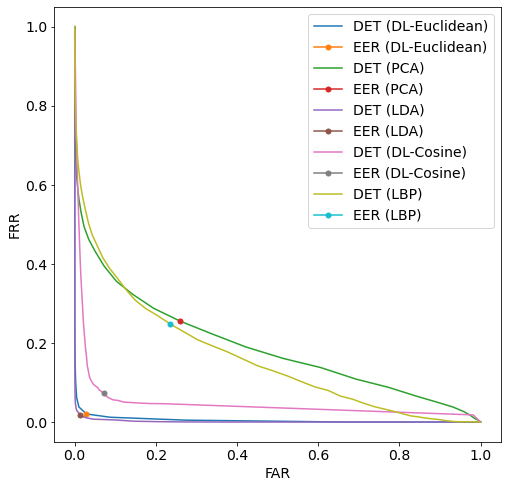

In [62]:
fig = plt.figure(figsize=figsize)
for method in tqdm(df_features.index):
    plt.plot(df_features.loc[method, 'far'], df_features.loc[method, 'frr'], label=f'DET ({method})')
    plt.plot(df_features.loc[method, 'eer_far'], df_features.loc[method, 'eer_frr'], marker="o", markersize=5, label=f'EER ({method})')
plt.ylabel('FRR')
plt.xlabel('FAR')
plt.legend()
plt.show()
if SAVE_OUTPUT:
    fig.savefig(output_folder + 'det' + img_format)

100%|██████████| 5/5 [00:00<00:00, 237.95it/s]


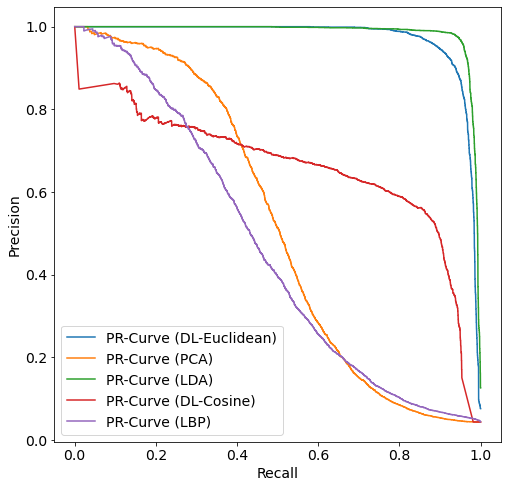

In [63]:
fig = plt.figure(figsize=figsize)
for method in tqdm(df_features.index):
    plt.plot(df_features.loc[method, 'recall'], df_features.loc[method, 'precision'], label=f'PR-Curve ({method})')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.legend()
plt.show()
if SAVE_OUTPUT:
    fig.savefig(output_folder + 'pr' + img_format)

In [64]:
"""Calculate the Area Under the PR-curve."""
for method in tqdm(df_features.index):
    pr_auc = metrics.auc(df_features.loc[method, 'recall'], df_features.loc[method, 'precision'])
    print(f'PR-AUC for {method}: {pr_auc}')

100%|██████████| 5/5 [00:00<00:00, 1250.17it/s]

PR-AUC for DL-Euclidean: 0.9715441171225072
PR-AUC for PCA: 0.5151049383915262
PR-AUC for LDA: 0.9853376104458217
PR-AUC for DL-Cosine: 0.6604881225140745
PR-AUC for LBP: 0.4603884886137576


In [65]:
"""Calculate the average precision scores"""
for method in tqdm(df_features.index):
    #average_precision_scores = sum([precision[i] * abs(recall[i]-recall[i-1]) for i in range(1, len(precision))])
    average_precision_scores = metrics.average_precision_score(genuine_id, df_features.loc[method, 'score'])
    print(f'Average Precision Scores for {method}: {average_precision_scores}') # Equivalent to PR-AUC

100%|██████████| 5/5 [00:00<00:00, 38.17it/s]

Average Precision Scores for DL-Euclidean: 0.9715461475289449
Average Precision Scores for PCA: 0.5151356504671463
Average Precision Scores for LDA: 0.9853387732625173
Average Precision Scores for DL-Cosine: 0.658849749164981
Average Precision Scores for LBP: 0.46043081437238187


### 2. Validation as identification system

<div class="alert alert-block alert-success">
<b>Q5: </b> Validate the systems in an identification scenario. 
</div>

Hint: Generate a Cumulative Matching Curve. Calculate and compare rank-1 performance among the four feature extraction techniques.

100%|██████████| 5/5 [00:00<00:00, 294.66it/s]


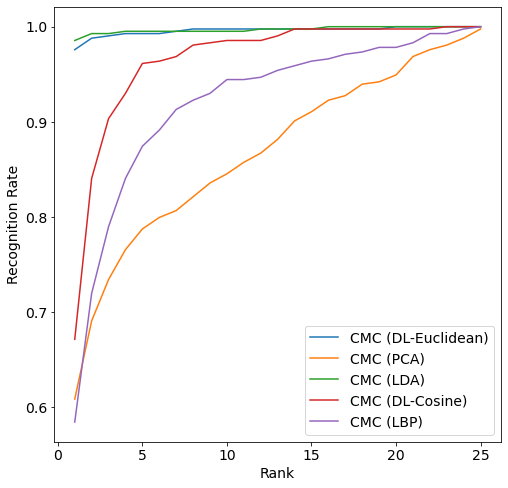

In [66]:
fig = plt.figure(figsize=figsize)
for method in tqdm(df_features.index):
    plt.plot(np.arange(1, rank), df_features.loc[method, 'cmc'], label=f'CMC ({method})')
plt.ylabel('Recognition Rate')
plt.xlabel('Rank')
plt.legend()
plt.show()
if SAVE_OUTPUT:
    fig.savefig(output_folder + 'cmc' + img_format)

In [67]:
"""compute the Rank-1 Recognition Rate."""
for method in tqdm(df_features.index):
    recognition_rate_rank_1 = df_features.loc[method, 'cmc'][0]
    print(f'Rank-1 Recognition Rate for {method}: {recognition_rate_rank_1}')

100%|██████████| 5/5 [00:00<?, ?it/s]

Rank-1 Recognition Rate for DL-Euclidean: 0.9758454106280193
Rank-1 Recognition Rate for PCA: 0.6086956521739131
Rank-1 Recognition Rate for LDA: 0.9855072463768116
Rank-1 Recognition Rate for DL-Cosine: 0.6714975845410628
Rank-1 Recognition Rate for LBP: 0.5845410628019324


## VI. Tasks
All tasks should be accompanied by a text providing information on the technique, steps, and the reasoning behind choosing the techniques.


### 1. Mandatory tasks
<b>The student should do all of the tasks indicated below</b>: 
1. Execute all the tasks indicated in the document above
2. Compare the 4 feature representations (LBP, PCA, LDA, DL using Siamese Networks) using the implemented validation metrics in Questions 2-5, and report on the performance. Please make it clear where in your report the comparison is made for each question. 

### 2. Tasks of choice
<b>The student should choose a number of tasks equivalent to <u>at least 3pts</u> from the list below (pts are not related to the grades)</b>. 

1. Evaluate your system on the other two datasets (AT&T, LFW). Feel free to subsample datasets if they are too memory-consuming on your system. (1pt.)
2. Implement 2 different face detectors and compare all techniques to the ground truth bounding boxes provided in <em>CalTechFacesDirs/ImageData.mat</em>. Look up the literature for methods to compare different face detectors. (1pt.)
3. Implement a classification-based scoring method, using an advanced classifier of your choice. Evaluate this system in an identification and verification scenario. (Hint: Follow steps introduced in section IV. Distance-based and classification-based scoring) (2pt.)
4. Experiment with the Siamese deep learning model by implementing a different loss function or a different distance calculation layer. (1pt.)
5. Pre-train your deep learning network on a different (larger) dataset and then fine-tune it with CALTECH and compare the results. (2pt.) 
6. Implement a different deep learning model* (2pt.)


e.g. performing task 4 and 5 is valid because their points sum up to 3. 

<em>Note: Indicate clearly which tasks you end up choosing and where we can find the implementations and/or results. </em>

[*] The implemented network has to be significantly different, adding some layers like batch normalisation, dropout, ... to the current network or increasing the kernel size, amount of filters and activation functions does not count.

#### Task 3

To implement a classification-based system (optional task 3), the following steps are expected:
1. For each person in the dataset leave one image out (E.g. the first image in the dataset) for the testset. This means the size of the test set equals the number of individuals in the data (=n).
2. Run the classifier of your choice and generate the classification probabilities for each test image.
3. Build your n by n similarity matrix, in which each row corresponds to a test image and each column corresponds to an individual in the dataset.
4. Calculate the evaluation metrics (E.g. ROC) based on the obtained similarity matrix to test your system in a verification or identification scenario.

In [68]:
from sklearn.svm import SVC

output_folder = 'output/classifier/'

#### Divide train-validation-test sets (one-shot learning)

In [69]:
unique_targets, unique_target_indices = np.unique(faces.target, return_index=True)
unique_target_mask = np.zeros(len(faces.target), dtype=bool)
unique_target_mask[unique_target_indices] = True

other = {'images': faces.images[~unique_target_mask], 'target': faces.target[~unique_target_mask]}
already_seen_targets = [set(), set()]
train_indices = []
for i in range(len(other['target'])):
    if other['target'][i] not in already_seen_targets[0]:
        if other['target'][i] not in already_seen_targets[1]:
             already_seen_targets[1].add(other['target'][i])
        else:
             already_seen_targets[0].add(other['target'][i])
        train_indices.append(i)
        
train_mask = np.zeros(len(other['target']), dtype=bool)
train_mask[train_indices] = True

other2 = {'images': other['images'][~train_mask], 'target': other['target'][~train_mask]}
already_seen_targets = [set(), set()]
validation_indices = []
for i in range(len(other2['target'])):
    if other2['target'][i] not in already_seen_targets[0]:
        if other2['target'][i] not in already_seen_targets[1]:
             already_seen_targets[1].add(other2['target'][i])
        else:
             already_seen_targets[0].add(other2['target'][i])
        validation_indices.append(i)

In [70]:
X_test, y_test = faces.images[unique_target_mask], faces.target[unique_target_mask]
X_train, y_train = other['images'][train_indices], other['target'][train_indices]
X_validate, y_validate = other2['images'][validation_indices], other2['target'][validation_indices]

#### Train DNN

In [71]:
SEED=42
np.random.seed(SEED)
tf.random.set_seed(SEED)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [72]:
distance_str = 'euclidean'
encoder, model = siamese.create_siamese_model(imshape, distance_str)

X_train_siamese, y_train_siamese = siamese.get_siamese_paired_data(X_train, y_train)
X_validate_siamese, y_validate_siamese = siamese.get_siamese_paired_data(X_validate, y_validate)
rms = Adam(learning_rate=0.0001)
model.compile(
    loss=siamese.contrastive_loss, 
    optimizer=rms, 
    metrics = [siamese.accuracy],
    run_eagerly=True)

epochs = 3
model.fit([X_train_siamese[:, 0], X_train_siamese[:, 1]], y_train_siamese, 
          validation_data=[[X_validate_siamese[:, 0], X_validate_siamese[:, 1]], y_validate_siamese],#validation_split=0.2,
          batch_size=32, verbose=1, epochs=epochs)

Epoch 1/3
63/63 [==============================] - 3s 38ms/step - loss: 0.0942 - accuracy: 0.7202 - val_loss: 0.0655 - val_accuracy: 0.8333
Epoch 2/3
63/63 [==============================] - 2s 35ms/step - loss: 0.0309 - accuracy: 0.9420 - val_loss: 0.0514 - val_accuracy: 0.8810
Epoch 3/3
63/63 [==============================] - 2s 34ms/step - loss: 0.0119 - accuracy: 0.9921 - val_loss: 0.0537 - val_accuracy: 0.8611


In [73]:
X_test_siamese, y_test_siamese = siamese.get_siamese_paired_data(X_test, y_test)
test_scores = model.predict([X_test_siamese[:, 0], X_test_siamese[:, 1]])
test_acc = metrics.accuracy_score(y_test_siamese, test_scores > 0.5)
print("Accuracy on the test set: {}".format(test_acc))

63/63 [==============================] - 0s 6ms/step
Accuracy on the test set: 0.991


#### Classify DL embeddings with an SVM

In [74]:
embedded = encoder(faces.images.astype(np.float32)).numpy()

In [75]:
X_test, y_test = embedded[unique_target_mask], faces.target[unique_target_mask]
X_train, y_train = embedded[~unique_target_mask], faces.target[~unique_target_mask]

In [76]:
classifier = SVC(C=10, probability=True)
classifier = classifier.fit(X_train, y_train)

#### Retrieve similarity matrix

In [77]:
similarity_matrix = classifier.predict_proba(X_test) # [size(test_image) x nb_individuals]

#### Evaluate Verification System 

In [78]:
def similarity_2_genuine_scores(classes, similarity_matrix):
    genuine_id = []
    scores = []
    for i1 in range(len(similarity_matrix)):
        for i2 in range(len(similarity_matrix[0])):
            scores.append(similarity_matrix[i1][i2])
            if classes[i1] == classes[i2]:
                genuine_id.append(1)
            else:
                genuine_id.append(0)
    return np.array(genuine_id), np.array(scores)

In [79]:
genuine_id, scores = similarity_2_genuine_scores(y_test, similarity_matrix)

In [80]:
f1_score_list = [f1_score(genuine_id, scores, threshold) for threshold in thresholds]

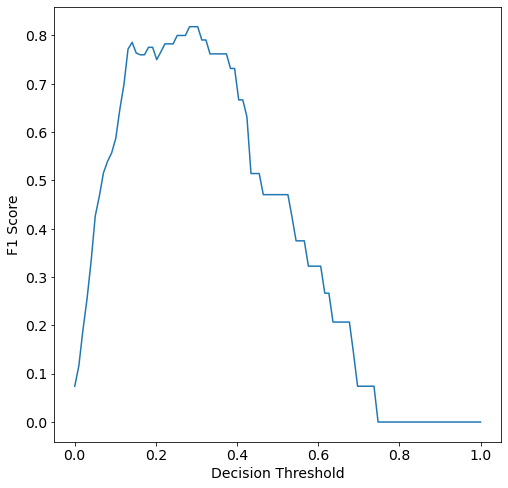

In [81]:
plt.figure(figsize=figsize)
plt.plot(thresholds, f1_score_list)
plt.ylabel('F1 Score')
plt.xlabel('Decision Threshold')
if SAVE_OUTPUT:
    plt.savefig(output_folder + 'f1_score' + img_format)

In [82]:
far_list = [fpr(genuine_id, scores, threshold) for threshold in thresholds]
tpr_list = [tpr(genuine_id, scores, threshold) for threshold in thresholds]
frr_list = 1-np.array(tpr_list)

In [83]:
"""Calculate (by approximation) the EER and plot it on the FAR-FRR curve."""
(eer_far, eer_frr), eer_threshold = fast_eer(far_list, frr_list, thresholds, return_threshold=True)

100it [00:00, 99983.41it/s]


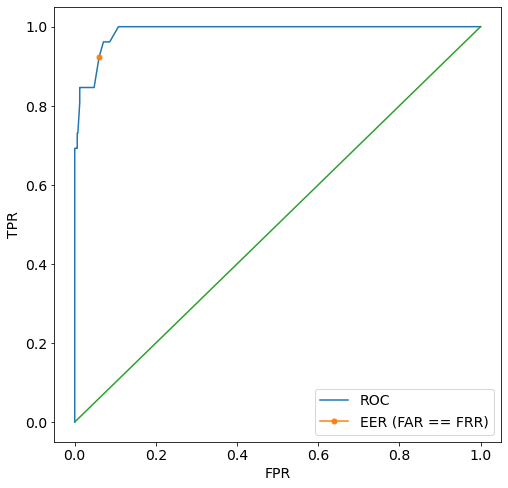

In [84]:
fig = plt.figure(figsize=figsize)
plt.plot(far_list, tpr_list, label=f'ROC')
plt.plot(eer_far, 1-eer_frr, marker="o", markersize=5, label=f'EER (FAR == FRR)')
plt.plot(thresholds, thresholds)
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.legend()
plt.show()
if SAVE_OUTPUT:
    fig.savefig(output_folder + 'roc' + img_format)

In [85]:
roc_auc = metrics.roc_auc_score(genuine_id, scores)
print(f'ROC-AUC: {roc_auc}')

ROC-AUC: 0.9877514792899408


In [86]:
"""Calculate and plot the Precision-Recall curve for this system"""
precision, recall, pr_thresholds = metrics.precision_recall_curve(genuine_id, scores)

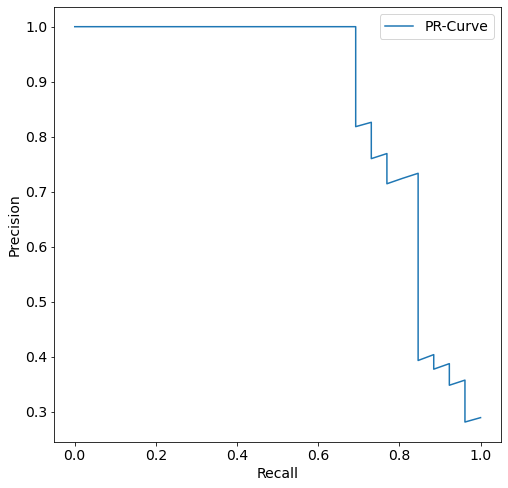

In [87]:
fig = plt.figure(figsize=figsize)
plt.plot(recall, precision, label=f'PR-Curve')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.legend()
plt.show()
if SAVE_OUTPUT:
    fig.savefig(output_folder + 'pr' + img_format)

In [88]:
"""Calculate the area under the PR-curve"""
pr_auc = metrics.auc(recall, precision)
print(f'PR-AUC: {pr_auc}')

PR-AUC: 0.863551212160067


In [89]:
"""Calculate the average precision scores"""
#average_precision_scores = sum([precision[i] * abs(recall[i]-recall[i-1]) for i in range(1, len(precision))])
average_precision_scores = metrics.average_precision_score(genuine_id, scores)
print(f'Average Precision Scores: {average_precision_scores}') # Equivalent to PR-AUC

Average Precision Scores: 0.8649779339336708


#### Evaluate Identification System

In [90]:
"""Calculate the Cumulative Matching Characteristic curve."""
rank = len(unique_targets)

similarity_matrix = pd.DataFrame(similarity_matrix) # [size(test_image) x nb_individuals]
similarity_matrix.index = unique_targets
cmc_list = cmc(unique_targets, similarity_matrix, rank)

100%|██████████| 25/25 [00:00<00:00, 24924.55it/s]


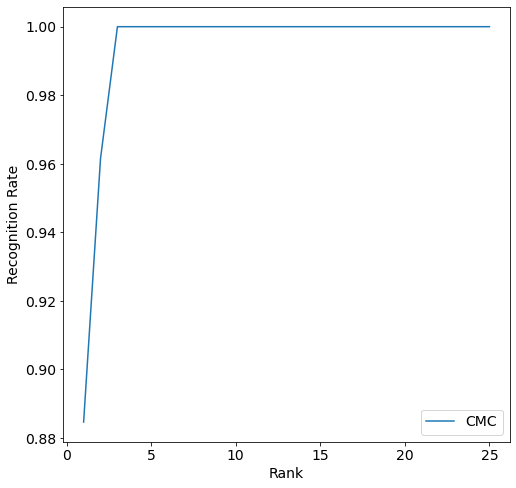

In [91]:
fig = plt.figure(figsize=figsize)
plt.plot(np.arange(1, rank), cmc_list, label=f'CMC')
plt.ylabel('Recognition Rate')
plt.xlabel('Rank')
plt.legend()
plt.show()
if SAVE_OUTPUT:
    fig.savefig(output_folder + 'cmc' + img_format)

In [92]:
"""Compute the Rank-1 Recognition Rate."""
recognition_rate_rank_1 = cmc_list[0]
print(f'Rank-1 Recognition Rate: {recognition_rate_rank_1}')

Rank-1 Recognition Rate: 0.8846153846153846
